In [7]:
import numpy as np
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
print(dataset.head(3))
values = dataset.values

# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_hours =30
n_out=6
n_features = 8
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, n_out)
    
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24 * 1 # 5 years data 1 year training
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, :n_out] # the problem is here 
test_X, test_y = test[:, :n_obs], test[:,:n_out]  # and here

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
train_y = train_y
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
(8760, 30, 8) (8760, 6) (35005, 30, 8) (35005, 6)


Train on 8760 samples, validate on 35005 samples
Epoch 1/3
 - 7s - loss: 0.3344 - val_loss: 0.2621
Epoch 2/3
 - 6s - loss: 0.1935 - val_loss: 0.1557
Epoch 3/3
 - 7s - loss: 0.1460 - val_loss: 0.1426


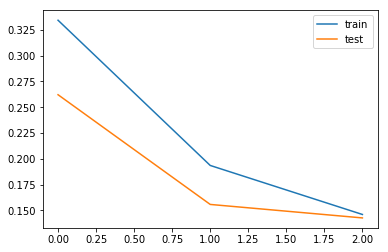

In [8]:

# design network
model = Sequential()
model.add(LSTM(4, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(n_out))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=3, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# The number of epochs is too small, at first I would like to make sure it works then tune the hyperparameters

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


In [9]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))

# invert scaling for forecast
pred_scaler = MinMaxScaler(feature_range=(0, 1)).fit(dataset.values[:,0].reshape(-1, 1)) 
inv_yhat = pred_scaler.inverse_transform(yhat)
print(inv_yhat.shape)
# invert scaling for actual
inv_y = pred_scaler.inverse_transform(test_y)
print(inv_y.shape)

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

(35005, 6)
(35005, 6)
Test RMSE: 189.400


In [10]:
inv_yhat = inv_yhat[:,0]
inv_y=inv_y[:,0]

In [11]:
print('predicted: ',inv_yhat)
print('real:' ,inv_y)

predicted:  [  3.04286     7.406884    6.121824  ... -10.307352   -7.0151763
  -3.4667058]
real: [36.       30.999998 19.999998 ... 24.999998 48.       48.999996]


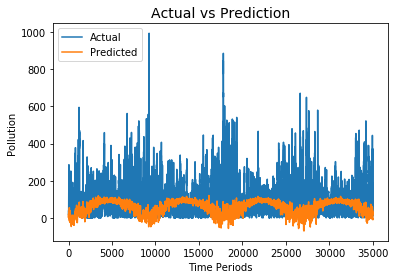

In [12]:
pyplot.title("Actual vs Prediction", fontsize=14)
#for i in range(10):
pyplot.plot(inv_y, label='Actual')
pyplot.plot(inv_yhat, label='Predicted')
pyplot.legend(loc="upper left") 
pyplot.xlabel("Time Periods")
pyplot.ylabel(dataset.columns.values[0].title())  # Get the header name and capitalize it
pyplot.show()